# Data understanding

In [1]:
# Importing standard liabraries for data exploration

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Uploading AirBnB data sets

calendar_df = pd.read_csv('calendar.csv')

listing_df = pd.read_csv('listings.csv')

reviews_df = pd.read_csv('reviews.csv')

## Exploring listings data

listing_df is going to be our primary source of information in this analysis

In [3]:
# Some of the numeric variables are presented in string format

listing_df[['host_response_rate','host_acceptance_rate']].head(5)

,host_response_rate,host_acceptance_rate
0,96%,100%
1,98%,100%
2,67%,100%
3,NaN,NaN
4,100%,NaN


In [4]:
# Quick function for converting object % to float

def percentage_to_float(x):
    '''converting object % to float'''
    return float(x.strip('%')) / 100

In [5]:
# Converting response_rate and acceptance_rate into numeric values with percentage_to_float function

listing_df['host_response_rate'] = listing_df['host_response_rate'].fillna('0%').apply(percentage_to_float)
listing_df['host_acceptance_rate'] = listing_df['host_acceptance_rate'].fillna('0%').apply(percentage_to_float)

In [6]:
# Another type of numeric variables presented in sting format 

listing_df[['price','weekly_price','monthly_price','security_deposit','cleaning_fee']].head(5)

,price,weekly_price,monthly_price,security_deposit,cleaning_fee
0,$85.00,NaN,NaN,NaN,NaN
1,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00
2,$975.00,NaN,NaN,"$1,000.00",$300.00
3,$100.00,$650.00,"$2,300.00",NaN,NaN
4,$450.00,NaN,NaN,$700.00,$125.00


In [7]:
# Quick function for converting financials to float

def financial_to_float(x):
    '''converting strings with commas and dollar sings into float '''
    x = x.replace(",", "")
    return float(x.strip('$'))

In [8]:
# Converting response_rate and acceptance_rate into numeric values

financials = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee']

for i in financials:
    listing_df[i] = listing_df[i].fillna('$0').apply(financial_to_float)

### Exploring categorical and numeric variables of listing_df

In [9]:
# Splitting for numeric and categorical variables

cat_listing_df = listing_df.select_dtypes(include = ['object'])
var_listing_df = listing_df.select_dtypes(include = np.number)

In [10]:
# Looking into correlation between numeric variables. Removing irrelevant columns

listing_corr_clean = var_listing_df.drop(columns = ['id', 'scrape_id', 'host_id', 'latitude',
                                                    'longitude', 'license', 'host_listings_count',
                                                    'calculated_host_listings_count', 
                                                    'host_total_listings_count'])

<AxesSubplot:>

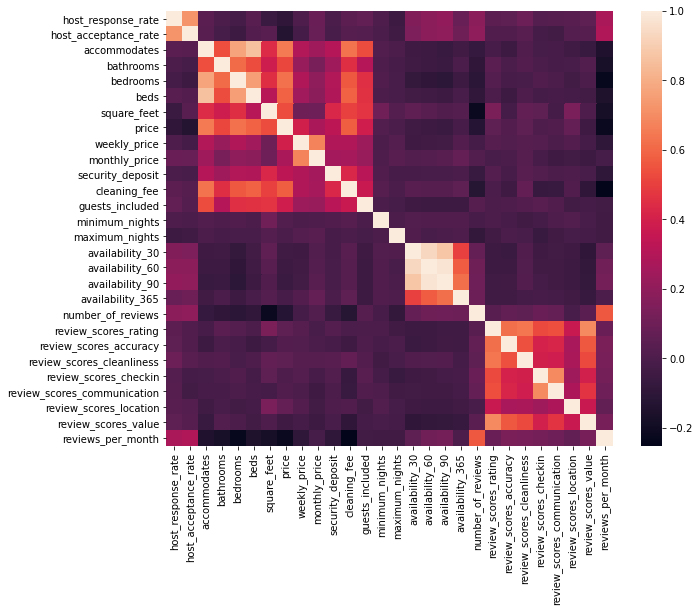

In [11]:
# Correlation heatmap

plt.subplots(figsize = (10,8))
sns.heatmap(listing_corr_clean.corr())

### Looking into listings correlations

__Host rate__

- host_response_rate
- host_acceptance_rate

__Observation__: interesting that response rate and acceptance rate are highly correlated. Could it be the case that hosts who response prospects are more likely accept their requests?

__Size of a property__

- accomadates
- bathrooms
- bedrooms
- beds
- guests included 
- square feet

__Observation__: potentially we can keep only beds and square feet as these are the least correlated features and can compliment each other.

__Availability__

- availability_30
- availability_60
- availability_90
- availability_365

__Observation__: all 30,60 & 90 days are highly correlated which potentially indicates that popular properties are always booked and less poppular are more likely to be available

__Reviews__

- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value 

potentially we can keep: review_scores_rating, review_scores_location and review_per_month as these are less corelated

## Stating business questions

After initial look into data we would like to answer three follosing questions:

- What is the busiest time of the year for Seattle?
- What are the most expensive neighbourhoods?
- Can we predict the price of a property based on its features?

First two questions we will answer in Data Understanding section as they don't require data modelling.

### What is the busiest time of the year for Seattle?

In order to answer our first business question we don't really need to build a sophisticated model but rather we can take a closer look into calendar data.

In [12]:
# Let's convert dates into month to identtify the busiest time of the year

import datetime as dt

calendar_df['date'] = pd.to_datetime(calendar_df['date'], format = '%Y-%m-%d')
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df.head(5)

,listing_id,date,available,price,month,year
0,241032,2016-01-04,t,$85.00,1,2016
1,241032,2016-01-05,t,$85.00,1,2016
2,241032,2016-01-06,f,NaN,1,2016
3,241032,2016-01-07,f,NaN,1,2016
4,241032,2016-01-08,f,NaN,1,2016


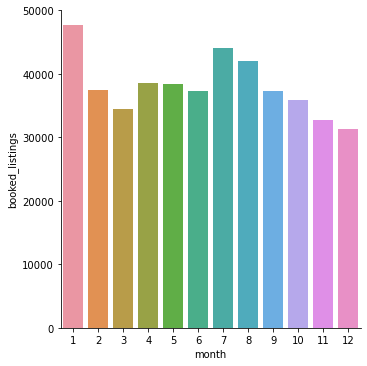

In [13]:
# We will focus only on year 2016 since we have only a single full year of data 
# Below we will look into total number of days per month booked across all properties in the Seatle

monthly_booked = calendar_df[(calendar_df['available'] == 'f') & (calendar_df['year'] == 2016)][['listing_id', 'month']].groupby(['month']).count()
monthly_booked = monthly_booked.reset_index()
monthly_booked.rename(columns={"listing_id": "booked_listings"}, inplace = True)

sns.catplot (x = 'month', y = 'booked_listings', data = monthly_booked , kind = 'bar')

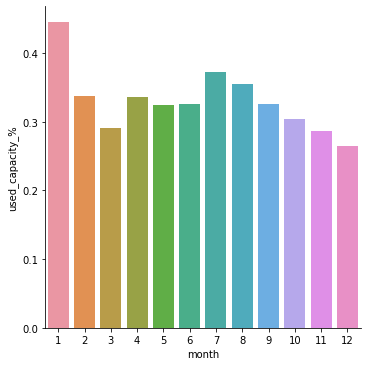

In [14]:
# Let's look into percentage of booked properties by month
# we can simply do it by dividing total 

capacity = calendar_df[calendar_df['year'] == 2016][['listing_id','month']].groupby(['month']).count()
capacity = capacity.reset_index()
capacity.rename(columns={"listing_id": "total_listings"}, inplace = True)
capacity = capacity.merge(monthly_booked, left_on='month', right_on='month')
capacity['used_capacity_%'] = capacity['booked_listings'] / capacity['total_listings']

sns.catplot (x = 'month', y = 'used_capacity_%', data = capacity , kind = 'bar')

Clearly January, July and August are the busiest months for Seattle as there are less places to book

### What are the most expensive neighbourhoods ?

As with busiest time question we don't really need to build a model we will simply do minor data manipulations

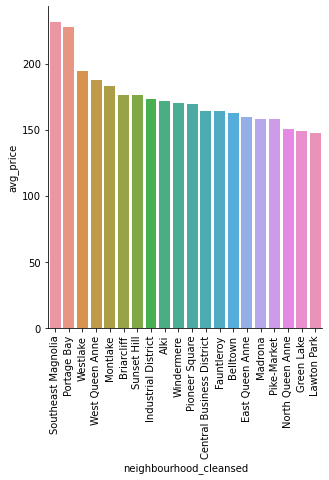

In [15]:
# Let's focus on neighbourhood_cleansed as this is neigbourhood column shows the most detailed description, 
# it also does not have any missing values.

avg_neighbourhood_price = listing_df[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').mean().reset_index()

# Let's take a look at top 20 most expensive neighbourhoods

top_20_neighbourhoods = avg_neighbourhood_price.nlargest(20, 'price', keep='first')
top_20_neighbourhoods.rename(columns={"price": "avg_price"}, inplace = True)

sns.catplot (x = 'neighbourhood_cleansed', y = 'avg_price', data = top_20_neighbourhoods , kind = 'bar')
plt.xticks(rotation=90);

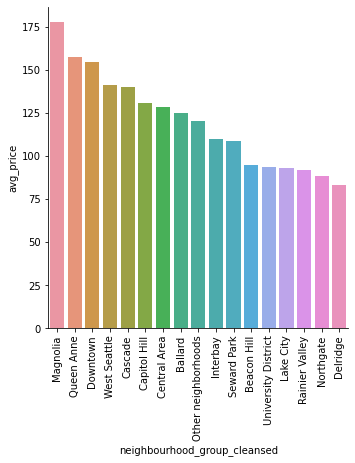

In [16]:
# Let's also look into neighbourhoods_grouped, it also does not have any missing values.

avg_neighbourhood_price = listing_df[['neighbourhood_group_cleansed','price']].groupby('neighbourhood_group_cleansed').mean().reset_index()

# Let's take a look at top 20 most expensive neighbourhoods_grouped

top_20_neighbourhoods = avg_neighbourhood_price.nlargest(20, 'price', keep='first')
top_20_neighbourhoods.rename(columns={"price": "avg_price"}, inplace = True)

sns.catplot (x = 'neighbourhood_group_cleansed', y = 'avg_price', data = top_20_neighbourhoods , kind = 'bar')
plt.xticks(rotation=90);

As we could see the most expensive neighbourhood groups are Magnolia, Queen Anne, Downtown and West Seattle.

For further analysis we will primarily focus on neighbourhood groups rather individual neighbourhoods as this provides less noise for our model.

## Looking into missing values

In [17]:
# calculating % of missing values

missing_listings_df = listing_df.isnull().mean()*100

# filtering results for columns with missing values

columns_with_missing_listings = missing_listings_df[missing_listings_df>0]

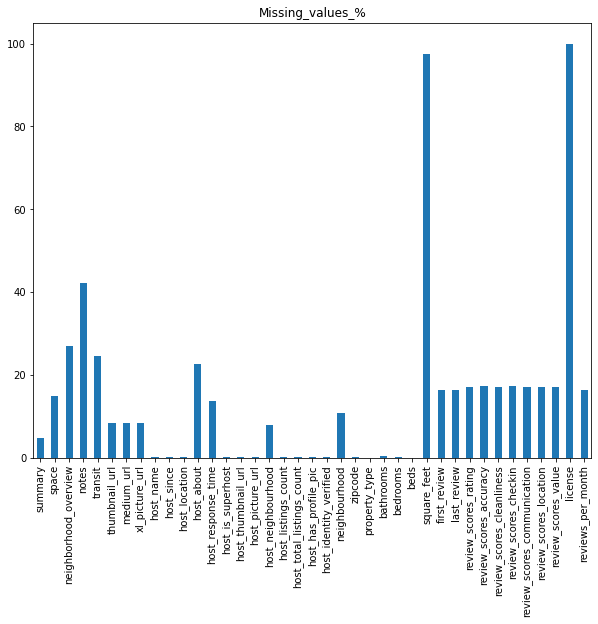

In [18]:
# plotting results

plt.subplots(figsize=(10,8))
columns_with_missing_listings.plot.bar(title = 'Missing_values_%');

Luckily for us there are few values missing that we've shorlisted for main question of price prediction:

- square_feet - with at almost 100% missing

- review_scores_rating, review_scores_location, reviews_per_month with almost 20% missing.

Reviews missing are likely to be new properties with few ranking - these could be candidates for imputing.

# Data preparation - Seatle AirBnB


In [19]:
# Let's re-upload AirBnB data this will help us align various data preparation processes in a single stream

calendar_df = pd.read_csv('calendar.csv')

listing_df = pd.read_csv('listings.csv')

reviews_df = pd.read_csv('reviews.csv')

As we've seen in the __Data understanding__ step: 

- Some of the attributes from Seattle dataset have missing data
    - Luckily for us only a small proportion of those attributes we are going to use in the model have around 10% of missing values. The rest of data is complete.
- We've identified highly correlated attributes from the same categories
    - Those attributes will be excluded from the training model
    
It certainly does not make sense to use all categorical and numerical values for our data model. Hence we will focus on the most reasonable predictors. For instance for numerical variables we will exclude all highly  correlated attributes, this will protect us from multicollinearity issues in the future. (See Data Understanding - correlation heatmap)

As for categorical, we will have to apply a bit of common sense and exclude such as: state, city, picture_url, name etc.

## Removing less usefull attributes

In [20]:
# Removing all rows from listing_df that don't have price records

listing_df = listing_df.dropna(subset=['price'],axis=0)

In [21]:
# Cleaning categorical variables. 

listing_df = listing_df.drop(columns = ['amenities', 'calendar_updated', 'cancellation_policy', 'city',
                                        'space', 'neighborhood_overview', 'notes', 'medium_url',
                                        'xl_picture_url', 'host_url', 'is_location_exact', 'country',
                                        'country_code', 'description', 'experiences_offered', 'calendar_last_scraped',
                                        'host_has_profile_pic','host_id','host_name','host_picture_url', 'host_about', 
                                        'host_verifications','host_thumbnail_url','listing_url','market','name',
                                        'neighbourhood_cleansed', 'jurisdiction_names', 'require_guest_profile_picture', 
                                        'smart_location', 'picture_url', 'scrape_id', 'state', 'street', 'summary', 
                                        'thumbnail_url', 'zipcode', 'host_location', 'host_neighbourhood', 
                                        'host_identity_verified', 'requires_license', 'instant_bookable', 
                                        'require_guest_phone_verification','license'])

In [22]:
# Cleaning nuemrical variables. 

listing_df = listing_df.drop(columns = ['last_scraped', 'host_response_rate', 'accommodates', 'bedrooms',
                                        'host_listings_count', 'host_total_listings_count',
                                        'guests_included', 'availability_60','availability_90', 'availability_365',
                                        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                                        'review_scores_communication', 'review_scores_value', 'longitude', 'latitude',
                                        'calculated_host_listings_count'])

In [23]:
# Let's alos drop columns with high % of missing values

listing_df = listing_df.drop(columns = ['first_review', 'host_acceptance_rate', 'last_review', 'monthly_price',
                                        'neighbourhood', 'reviews_per_month', 'security_deposit', 'square_feet',
                                        'transit', 'weekly_price'])

## Data Cleaning

### Numerical functions

In [24]:
# Defining fucntions for cleaning numerical values

# Function for converting string to datetime
import datetime
def str_to_date(x):
    '''function for converting string to datetime'''
    x = datetime.datetime.strptime(x, "%Y-%m-%d").date()
    return x

# Function for filling missing values with mean 
def fill_mean(x):
    '''Function for filling missing values with mean'''
    x  = x.fillna(x.mean())
    return x
    
# Let's re-use our financial_to_float function from data exploration step
def financial_to_float(x):
    '''function for converting text values with $ into float variables'''
    x = x.replace(",", "")
    return float(x.strip('$'))


### Categorical functions

In [25]:
# Defining fucntions for cleaning categorical values

# Here we will replace missing categorical variables with the most frequent value - mode 
def impute_nan_most_frequent_category(DataFrame,ColName):
    # .mode()[0] - gives first category name
     most_frequent_category=DataFrame[ColName].mode()[0]
    
    # replace nan values with most occured category
     DataFrame[ColName + "_Imputed"] = DataFrame[ColName]
     DataFrame[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)

### Assembling main function

In [26]:
# Specifying financials, numerics and categorrical_variable - attributes that we are going to clean 
# in the main function

financials = ['price_x', 'cleaning_fee', 'extra_people']

numerics = [['bathrooms', 'beds', 'cleaning_fee', 'review_scores_rating', 'review_scores_location', 'extra_people']]

categorical_varaibles = ['host_response_time', 'host_is_superhost', 'property_type', 'host_response_time',
                         'host_is_superhost', 'neighbourhood_group_cleansed', 'property_type', 'room_type',
                         'bed_type']


# Defining main cleaning function

def clean_data (listing_df,calendar_df):
    '''
    INPUT
    listings_df - dataframe containing listings data
    calendar_df - dataframe with availability and prices
    
    OUTPUT
    full_df - table that consits both relevant listing and calendar columns:
    1. string containing dates are converted into integers
    2. string containing $ singns converted into float
    2. relevant missing values are imputed with mean or mode.
    3. categorical variable are one-hot encoded
    '''
    # merging listings and calendar at this step
    listing_df = listing_df.rename(columns={"id": "listing_id"})
    full_df = pd.merge(calendar_df, listing_df, on = 'listing_id')
    
    # subsetting only rows with price from calendar - price on available dates
    full_df = full_df[pd.notnull(full_df["price_x"])]
    
    # we fill nan for host_since with '2016-01-04' - the scrape date
    full_df['host_since'] = full_df['host_since'].fillna(str('2016-01-04'))
    
    # cleaning date columns
    full_df['host_since'] = full_df['host_since'].astype(str).apply(str_to_date)
    full_df['host_since_year'] = pd.DatetimeIndex(full_df['host_since']).year
    full_df['host_since_year'] = full_df['host_since_year'].astype(int)
    full_df['date'] = full_df['date'].astype(str).apply(str_to_date)
    full_df['month'] = pd.DatetimeIndex(full_df['date']).month
    full_df['month'] = full_df['month'].astype(int)
    
    # formatting financial values
    for i in financials:
        full_df[i] = full_df[i].fillna('$0').apply(financial_to_float)
        
    # Imputing low 10% of missing numerics with mode values
    for i in numerics:
        full_df[i] = full_df[i].apply(fill_mean, axis = 0)
    
    # Imputing low 10% of missing categorical with mode values
    for i in categorical_varaibles:
        impute_nan_most_frequent_category(full_df,i)
        
    # dropping less useful numeric columns 
    full_df = full_df.drop(columns = ['host_since', 'date', 'price_y', 'listing_id'])
    
    # dropping less used cat columns 
    full_df = full_df.drop(columns = categorical_varaibles)
    full_df = full_df.drop(columns = ['available', 'has_availability'])
    
    # One-hot encoding for categorical variables
    cat_vars = full_df.select_dtypes(include=['object']).copy().columns

    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        full_df = pd.concat([full_df.drop(var, axis=1), 
                                       pd.get_dummies(full_df[var], 
                                       prefix=var, prefix_sep='_d', drop_first=True)], axis=1)

    
    return full_df

In [27]:
# Applying clean data fuction to listing and calendar data frames

full_df = clean_data(listing_df, calendar_df)

# Data Modelling

In [28]:
# importing sklearn librbaries for data modelling

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [29]:
# importing pre-processed data - look in 'Data Preparation' for detailed steps

clean_listings_df = full_df

## Feature Scaling 

In [30]:
# At this step we will normalise and standartise our data by doing it within single pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('norm_scaler', MinMaxScaler()),   
    ])

In [31]:
# We receive our output in array

clean_listings_tr = num_pipeline.fit_transform(clean_listings_df)

# Building new df with tranformed data

clean_listings_tr = pd.DataFrame(clean_listings_tr, columns = clean_listings_df.columns,
                                  index = clean_listings_df.index) 

## Train / test split

In [32]:
# Split into explanatory and response variables

X = clean_listings_df.drop(['price_x'], axis = 1)
y = clean_listings_df['price_x'].copy()

# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

## Linear Regression

For predicting price of a property we will use regression algorithms since we are working with continous dependent variable. 

In [33]:
# Testing on Linear regression

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(normalize=True)

In [34]:
# Predict and score the model

y_test_preds = lm_model.predict(X_test)

"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.5926181831561046 on 280363 values.'

As we can see Linear Regresion is underfitting our data since we achieved only 0.59 for R^2. This is likely to happen due to non-linear connections between attributes.

Let's use some more serious model for such cases.

## Random Forest

In [35]:
# Let's use Random Forest to find more comlex non-linear relationships in data

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [36]:
# Grid search feature will help us to find the right combination of max_features and n_estimators for our model

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10], 'max_features':[2,3,4]},
    ]

forest_reg = RandomForestRegressor()

# We also specify number of cross validations

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [37]:
# If we continue to search with higher number of cross-validation (cv), the score may improve.
# We can also get the best estimator directly 

grid_search.best_estimator_

# If GridSearchCV is initialized with refit=True (which is the default), 
# then once it finds the best estimator using cross-validation, it retrains it on the whole training set.

# Evaluations scores are also available

cvres = grid_search.cv_results_

for mean_score, params in zip (cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

14.87374627685103 {'max_features': 2, 'n_estimators': 3}
14.659853811033017 {'max_features': 2, 'n_estimators': 10}
14.6341585222875 {'max_features': 2, 'n_estimators': 30}
14.777197007842984 {'max_features': 4, 'n_estimators': 3}
14.653852366710582 {'max_features': 4, 'n_estimators': 10}
14.614835063887893 {'max_features': 4, 'n_estimators': 30}
14.824822849876988 {'max_features': 6, 'n_estimators': 3}
14.653355273211632 {'max_features': 6, 'n_estimators': 10}
14.617100663465946 {'max_features': 6, 'n_estimators': 30}
14.761671585129593 {'max_features': 8, 'n_estimators': 3}
14.649999152349055 {'max_features': 8, 'n_estimators': 10}
14.611514784045527 {'max_features': 8, 'n_estimators': 30}
14.646462791565614 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
14.611524459965722 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
14.630909604448687 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
14.611481380697086 {'bootstrap': False, 'max_features': 3, 'n_es

In [38]:
# Predict and score the model

y_test_preds = grid_search.predict(X_test)

"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.980508347396863 on 280363 values.'

In [39]:
# So far this is the best model we could produce 

grid_search.best_estimator_

# bootstrap=False, max_features=4, n_estimators=10

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10)

Random Forest clearly wins Linear regression with high R^2 on test data and relatively low root mean squared error.

Now that we know Random Forest is more appropriate model for predicting property prices let's look into the importance of predicting attributes

In [55]:
# Let's analyse importance of predicting attributes

headers = ["feature", "score"]

feature_importances = grid_search.best_estimator_.feature_importances_

attributes = X_train.columns

values = sorted(zip(attributes, feature_importances), reverse = True)

rdm_forest_feature_importance = pd.DataFrame(values, columns = headers).sort_values(by=['score'], ascending=False)

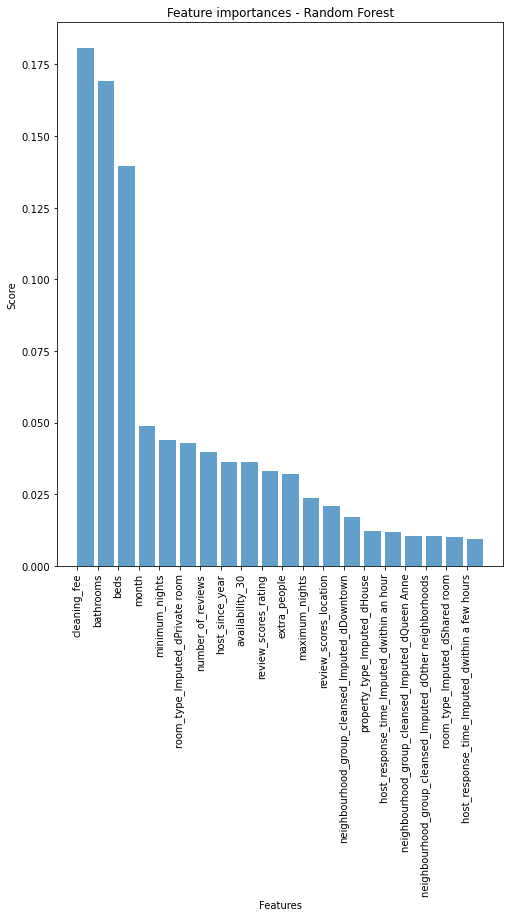

In [62]:
# plot feature importances for top 15 features

features = rdm_forest_feature_importance['feature'][:20]
scores = rdm_forest_feature_importance['score'][:20]
y_pos = np.arange(len(features))

 
plt.figure(figsize=(8,10))
plt.bar(y_pos, scores, align='edge', alpha=0.7)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances - Random Forest')
plt.show()

# Conclusion

On completion of Seattle AirBnB booking analysis we could clearly find the busiest time of the year in January, July and August. With the most expensive neighbourhoods being Magnolia, Queen Anne and Downtown.

We could also predict the price of a property based on its features. In particular, we’ve found that Random Forest is probably one of the best kinds of model to predict continuous price metrics based on numerical and one-hot encoded categorical features. The strongest indicators of booking prices are cleaning fee, number of bathrooms and beds followed by minimum number of nights, room type and number of reviews. It should be mentioned that although individual neighbourhood features (one-hot encoded) scored relatively low individually, they are likely to be quite an important feature if combined.
